In [85]:
import pandas as pd

## Define and run evalMetrics on Timeseries

In [86]:
# metric
my_metric = c3.SimpleMetric(id = "AverageX_SimulationSample",
                            name = "AverageX_SimulationSample",
                            description = "Calculates average of property X for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",
                            expression = "avg(avg(normalized.data.propertyX))"
                           )

In [105]:
# spec
my_spec = c3.EvalMetricsSpec(
            ids = ["EnsNo_1_SimNo_0"],
            expressions = ["AverageX_SimulationSample"],
            start = "2017-02-01T20:08:00.000",
            end = "2017-02-01T20:26:00.000",
            interval = "MINUTE" 
            )

In [106]:
# result
evalMetricsResult = c3.SimulationSample.evalMetricsWithMetadata(
                                                        spec=my_spec,
                                                        overrideMetrics=[my_metric])

In [107]:
# convert EvalMetricsResult to Pandas DataFrame
df = c3.EvalMetricsResult.toPandas(result=evalMetricsResult)

# Post process dataframe to add 'timestamp' column
df['source'] = df.index.str.split('_').str[0:-1]
df['timestamp'] = pd.to_datetime(df.index.str.split('_').str[-1],format="%Y-%m-%dT%H:%M:%S.%f")

<AxesSubplot:xlabel='timestamp'>

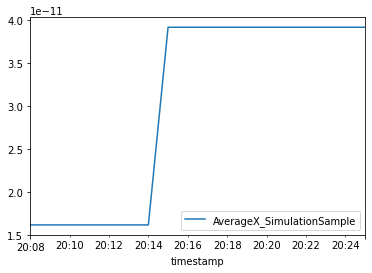

In [108]:
df.plot(x='timestamp',y='AverageX_SimulationSample')

## See original data

In [92]:
def EvaluateResultToPandas(result=None, eval_spec=None):
    """
    Take an EvaluateResult type and build a usable Pandas DataFrame from it.
    If you pass the EvaluateSpec you used to eval_spec (either c3.EvaluateSpec
    or dict type), this function will name the columns correctly as well.
    Arguments:
      result: A c3.EvaluateResult type which contains the results you want to
        turn into a Pandas DataFrame. [Required]
      eval_spec: Either a dict or c3.EvaluateSpec containing the spec you used
        to get the results. If no eval_spec is passed, by default the columns
        will be named 'c0', 'c1', ...
    Returns:
      A Pandas DataFrame containing the EvaluateResult data.
    """

    # Check whether the input is None
    if result is None:
        raise ValueError("You must pass a non-None value.")

    # Check whether the input is the right type
    # For now, we do a string comparison because the 'c3' object
    # Is not in scope in this function.
    if str(type(result)) != "c3.EvaluateResult":
        raise ValueError("You must pass a c3.EvaluateResult type.")

    # Find number of columns in the result
    num_columns = len(result.tuples[0].cells)

    # Get column names
    if eval_spec is None:
        column_names = ["c{}".format(i) for i in range(num_columns)]
    else:
        if type(eval_spec) is dict:
            column_names = eval_spec["projection"].split(",")
        elif str(type(eval_spec)) == "c3.EvaluateSpec":
            # For now, we do a string comparison because the 'c3' object
            # Is not in scope in this function.
            column_names = eval_spec.projection.split(",")
        else:
            raise RuntimeError(
                "eval_spec should be either a dict or c3.EvaluateSpec, Type {} not supported".format(
                    type(eval_spec)
                )
            )

        if len(column_names) != num_columns:
            raise RuntimeError(
                "Eval Spec doesn't have correct number of columns! Has {} expected {}. Did you use the right Spec?".format(
                    len(column_names), num_columns
                )
            )

    # Initialize the results dict
    results = {}
    for col in column_names:
        results[col] = []

    # Fill the results dict
    for row in result.tuples:
        for i in range(num_columns):
            results[column_names[i]].append(row.cells[i].value())

    # Build and return the final Pandas DataFrame
    try:
        import pandas as pd

        return pd.DataFrame(results)
    except ImportError as e:
        # Trick from https://stackoverflow.com/questions/6062576/adding-information-to-an-exception/6062799
        raise type(e)(e.message + " EvaluateResultToPandas needs pandas to work!")
    except Exception as e:
        raise e

In [93]:
px = EvaluateResultToPandas(
    c3.SimulationModelOutput.evaluate(
    spec = {
        'projection': "propertyX",
        'filter':"parent.id=='SMOS_EnsNo_1_SimNo_0'",
        'limit': 10
    }
)
)

In [94]:
dt = EvaluateResultToPandas(
    c3.SimulationModelOutput.evaluate(
    spec = {
        'projection': "start",
        'filter':"parent.id=='SMOS_EnsNo_1_SimNo_0'",
        'limit': 10
    }
)
)

df_orig = pd.DataFrame(dt)
df_orig['timestamp'] = dt
df_orig['propertyX'] = px
df_orig['timestamp'] = pd.to_datetime(df_orig['timestamp'], format="%Y-%m-%d %H:%M:%S")

In [98]:
import matplotlib.pyplot as plt

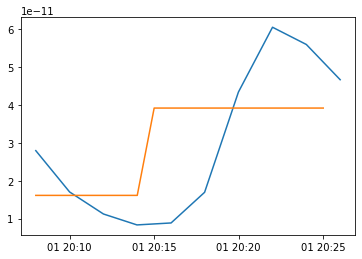

In [109]:
plt.figure()
plt.plot(df_orig['timestamp'], df_orig['propertyX'])
plt.plot(df['timestamp'], df['AverageX_SimulationSample'])